# Exercise 2

Install necessary packages:

In [1]:
%pip install tabulate matplotlib numpy

Note: you may need to restart the kernel to use updated packages.


In [2]:
import os
from tqdm.auto import tqdm

import numpy as np
from matplotlib import pyplot as plt
import tabulate

/Users/dima/miniconda3/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Rice encoding and decoding functions

In [3]:
def rice_encode(number, k) -> str:
    """
    Rice encode a number n with parameter k.

    Input:
        number: the number to be encoded
        k: the parameter of the Rice code (k >= 0)

    The idea is to split the number into two parts: the quotient and the remainder.
    The quotient is encoded as a unary number, and the remainder is encoded as a binary number.
    """
    quotient = number >> k
    remainder = number & ((1 << k) - 1)

    return '1' * quotient + '0' + format(remainder, '0' + str(k) + 'b')

In [4]:
def rice_decode(code, k) -> int:
    """
    Rice decode a code with parameter k.

    Input:
        code: the Rice code to be decoded
        k: the parameter of the Rice code (k >= 0)
    
    The idea is to find the first 0 in the code. The number of 1s before the 0 is the quotient,
    and the k bits after the 0 is the remainder.
    """
    quotient = code.find('0')
    remainder = int(code[quotient + 1:quotient + 1 + k], 2)
    return (quotient << k) + remainder

Test encode and decode functions:

In [5]:
assert rice_decode(rice_encode(100, 3), 3) == 100

Should also work with any number of zeros padded to the right:

In [6]:
assert rice_decode(rice_encode(100, 3).ljust(100, '0'), 3) == 100

## Helper functions

In [7]:
def bits_to_bytes(bit_string:str) -> bytes:
    """
    Convert a string of bits to a bytes object.
    """
    padded = bit_string + '0' * ((8 - len(bit_string) % 8) % 8)
    return bytes(int(padded[i:i+8], 2) for i in range(0, len(padded), 8))

In [8]:
def bytes_to_bits(byte_data:bytearray) -> str:
    """
    Convert a bytes object to a string of bits.
    """
    return ''.join(format(byte, '08b') for byte in byte_data)

Test helper functions:

In [9]:
number = 100500

# Generate a bit string from a number
bit_string = bin(number)[2:]

# Add padding to the bit string
padding = (8 - len(bit_string) % 8) % 8
bit_string = bit_string.zfill(len(bit_string) + padding)

bits = bytes_to_bits(bits_to_bytes(bit_string))

assert int(bits, 2) == number

## Encode a file

In [10]:
def encode_file(input_file, output_file, k):
    """
    Encode a file using Rice encoding with parameter k.
    """

    # Read input file
    with open(input_file, 'rb') as file:
        input_data = file.read()

    # Convert input_data to a Rice encoded bit string
    bit_string = ''.join([rice_encode(n, k) for n in input_data])

    # Add padding to the right of the bit string
    # to make it divisible by 8 and convetable to a bytes object
    padding = (8 - len(bit_string) % 8) % 8
    bit_string = bit_string.ljust(len(bit_string) + padding, '0')

    encoded_data = bits_to_bytes(bit_string)

    # Save to the output file
    with open(output_file, 'wb') as file:
        file.write(encoded_data)

In [11]:
def decoded_file(input_file, output_file, k):
    """
    Decode a file using Rice encoding with parameter k.
    """
    # Read input file
    with open(input_file, 'rb') as file:
        input_data = file.read()

    # Convert input_data to a bit string
    bit_string = bytes_to_bits(input_data)

    # decode
    decoded_data = []
    start = 0
    while start < len(bit_string):
        # Find the next 0 in the bit string
        q = bit_string.find('0', start)

        # If there is no 0 or there is no k bits after the 0
        if q == -1 or q + k >= len(bit_string):
            break

        # Rice decode a chunk of the bit string
        value = rice_decode(bit_string[start:q + k + 1], k)

        decoded_data.append(value)

        # Move the start pointer to the next chunk
        start = q + k + 1

    # Save decoded data to the output file
    with open(output_file, 'wb') as file:
        file.write(bytes(decoded_data))

## Processing

In [12]:
FILES = ["Sound1.wav", "Sound2.wav"]

table_data = []

for file in FILES:
    sample_name = os.path.splitext(os.path.basename(file))[0]

    original_size = os.path.getsize(file)
    output_file_name = sample_name + '_Enc.ex2'

    # Encode the file with k = 4
    encode_file(file, output_file_name, 4)
    encoded_4_size = os.path.getsize(output_file_name)

    # Decode the file
    decoded_output_file_name = sample_name + '_Enc_Dec.wav'
    decoded_file(output_file_name, decoded_output_file_name, 4)

    # Encode the file with k = 2 
    encode_file(file, output_file_name, 2)
    encoded_2_size = os.path.getsize(output_file_name)

    # Decode the file
    decoded_output_file_name = sample_name + '_Enc_Dec.wav'
    decoded_file(output_file_name, decoded_output_file_name, 2)

    # Calculate compression percentage for k = 4 and k = 2
    compression_percentage_4 = (1 - encoded_4_size / original_size) * 100
    compression_percentage_2 = (1 - encoded_2_size / original_size) * 100

    # Save the results
    table_data.append([file, original_size, encoded_4_size, encoded_2_size, compression_percentage_4, compression_percentage_2])

## Display the results

In [13]:
table = tabulate.tabulate(table_data,  tablefmt='html', headers=["", "Original size", "Rice (K = 4 bits)", "Rice (K = 2 bits)", "% Compression (K = 4 bits)", "% Compression (K = 2 bits)"])
table

,Original size,Rice (K = 4 bits),Rice (K = 2 bits),% Compression (K = 4 bits),% Compression (K = 2 bits)
Sound1.wav,1002088,1516265,4115718,-51.3106,-310.714
Sound2.wav,1008044,1575347,4348595,-56.2776,-331.389


## Further development

For further development, I would like to explore how K-parameter affects the compression ratio. I ran the program with different K values and plot the compression ratio against K. The result is shown below:

In [14]:
# Generate a list of numbers from 2 to 21
Ks = range(2, 22)

results = []

for k in tqdm(Ks):
    # Encode the file with k
    output_file_name = "Sound1_Enc.ex2"
    encode_file("Sound1.wav", output_file_name, k)
    encoded_size = os.path.getsize(output_file_name)

    # Calculate compression percentage
    compression_percentage = (1 - encoded_size / original_size) * 100

    # Save the results
    results.append([k, compression_percentage])

results = np.array(results)

100%|██████████| 20/20 [00:10<00:00,  2.00it/s]


Plot the results:

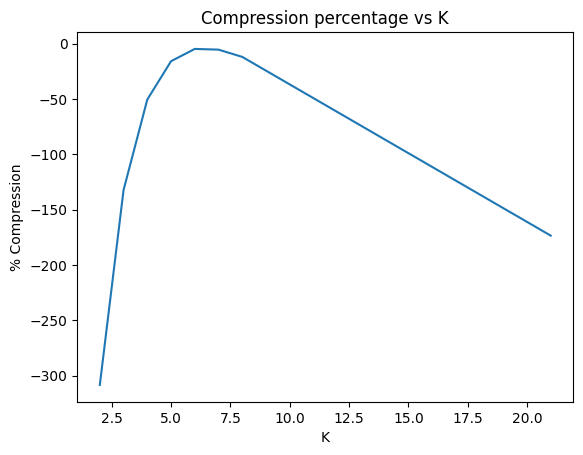

In [15]:
plt.title('Compression percentage vs K')
plt.xlabel('K')
plt.ylabel('% Compression')
plt.plot(results[:, 0], results[:, 1])

Unfortunately, the compression ratio does not seem to be higher than 1 for any K value. The overhead of the encoding is too large compared to the file size.